<h1> Imports </h1>

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

/Users/gpoulsen@apamail.org/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


<h1> Functions </h1>

In [2]:
def dropOutliers(df):

    toRemove = [] #List of outliers to remove

    yrs = df['Year'].unique() 
    g = df.groupby('Year') #Define groups for every year we'll examine

    #Loop through groups
    for y in yrs:

        s = g.get_group(y)['Pop'] #Get Group

        iq = s.describe().loc['75%'] - s.describe().loc['25%'] #Calculate the inner quartile
        ub = s.describe().loc['75%'] + 1.5 * iq #Create Lower Bound considered outliers
        lb = s.describe().loc['25%'] - 1.5 * iq #Creatre Uppper Bound considered outliers

        toRemove.extend(list(s[~s.between(lb,ub)].index)) #Store outliers to remove later
        df = df[~df.index.isin(toRemove)]
        
    return df

def cleanFrame(df):

    df['Pop'] = df['Pop'].astype(int) #Format response as int

    df.drop(columns=['State','County']) #Drop Numeric Identifiers
    df['County'] = df['Name'].str.split(",").str[0] #Split Name Column: County
    df['State'] = df['Name'].str.split(",").str[1] #Split Name Column: State

    df.index = df['State'] + "-" + df['County'] + "-" + df['Year'] #Set Unique Identifier
    df = df.drop(columns='Name') #Drop Name Column

    df = df[['County','State','Year','Pop']] #Reorder Columns

    return df

<h1> Requesting County Populations from 2005 to 2021 </h1>

In [3]:
apiKey = 'fc8e94a76785a060f4aba9a659b4c84157f46dea' #I should omit this later

cols = ['Name','Pop','State','County','Year'] #Labels for my df
df = pd.DataFrame(columns=cols) #Create empty frame

yrs = [*range(2005,2022)] #Consider all years
yrs.remove(2020) #except for 2020 which was not released due to issues with Covid

#Get All Available Years
for y in yrs:

    url = 'https://api.census.gov/data/' + str(y) + '/acs/acs1?get=NAME,B01001_001E&for=county:*&key=' + apiKey #URL for Query
    response = requests.request("GET",url) 
    
    cLen = len(response.json()[1:]) 
    year = np.array([str(y) for x in range(cLen)]).reshape(cLen,1) #Create a year column for labeling our response

    dt = np.array(response.json()[1:]) #Format response as np array
    dt = np.hstack((dt,year)) #Add a year column to data
    dt = pd.DataFrame(dt, columns=cols) #Format as a frame

    df = pd.concat([df,dt],ignore_index=True) #Concatonate w/ our loaded data as of thus far

print("Avg. num. of data pts. for each region " + str(df['Name'].value_counts().mean())) #A rough summurative check on what we've loaded

Avg. num. of data pts. for each region 15.2995337995338


In [4]:
dfc = df

In [5]:
df = dfc

<h1> Clean Data </h1>

In [6]:
df = cleanFrame(df)
m = len(df)
df = dropOutliers(df)
n = len(df)

print("Percentage of data retained after removing outliers "+ str(n/m))

Percentage of data retained after removing outliers 0.8843604784032909


<h1> Visualize Populations Over Time </h1>

/Users/gpoulsen@apamail.org/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/gpoulsen@apamail.org/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/gpoulsen@apamail.org/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/var/folders/k_/0qtp8gm127b6d1j49mgjkwkh0000gq/T/ipykernel_45960/2835602518.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabel

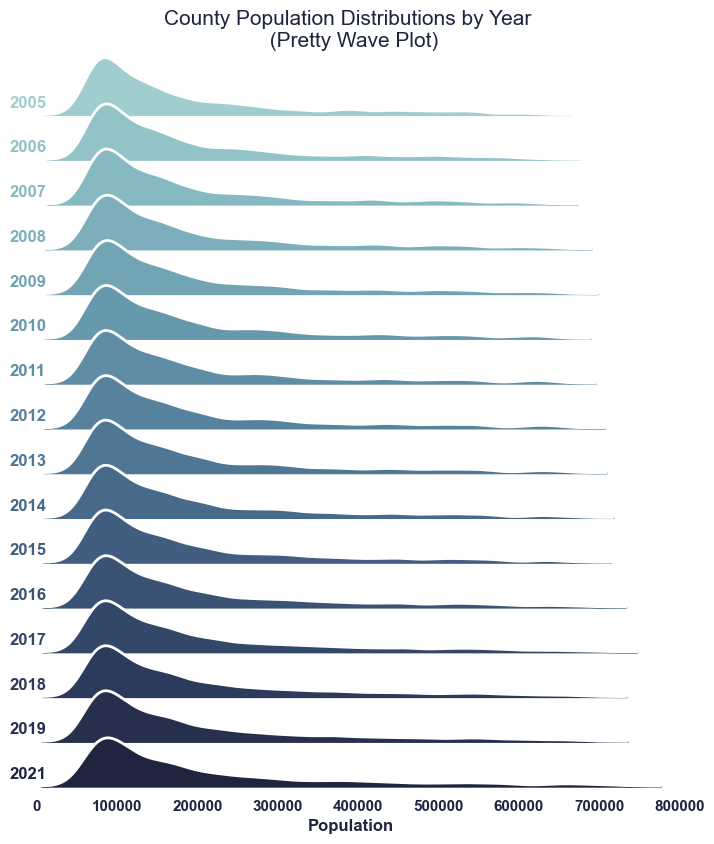

In [164]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "figure.facecolor":(0, 0, 0, 0)}) #Set Theme (.6, .45, .2, .4)
pallette = sns.cubehelix_palette(16, rot=-.25, light=.75) #Set a linearly changing color pallete with 16 colors through the rainbow
grid = sns.FacetGrid(df, row="Year", hue="Year", aspect=15, height=.5, palette=pallette) #Create a grid with an axis for each distribution


grid.map(sns.kdeplot, "Pop", bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5) # For Each Axis, Plot a filled KDEplot based on Pop.
grid.map(sns.kdeplot, "Pop", clip_on=False, color="white", lw=2, bw_adjust=.5) #For Each Axis, Plot a line KDEplot based on Pop.


def label(x, color, label): #Function to label each axis
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    


grid.map(label, "Pop") #Label each axis
grid.figure.subplots_adjust(hspace=-.25) #Overlap each axis

grid.set_titles("") #Remove labels on each axis
grid.set(yticks=[], ylabel="")

ax = grid.axes[-1][0] #Locate the last plot
col = ax.get_children()[2].get_color() #Get color used in the last plot
ax.set_xlabel("Population", fontdict={'weight':'bold','color':col}) #Set the label bold & colored
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'weight':'bold','color':col}) #Set the ticks bold and coloredd
grid.axes[0][0].set_title("County Population Distributions by Year \n (Pretty Wave Plot)",fontdict={'color':col,'fontsize':15}) #Set Title

grid.despine(bottom=True, left=True) #get rid of spine